## Modelado de temas mediante redes de documentos

#### Este notebook muestra la construcción de un sistema de modelado de temas mediante el análisis de un conjunto de datos de palabras.

##### Integrantes: Isaac Cerda; David Guamán; Christian Jácome; Mateo Jaramillo; David Navarrete

### Importación de Bibliotecas

In [1]:
# Instalar dependencias
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install joblib
!pip install scipy
# !pip install nbstripout
# !pip install jupytext

### Paso 1: Preparación de Datos

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline


### Paso 2: Cargar el Dataset

In [3]:
word_data = pd.read_csv("words_ux.csv")

word_data.head()

,Words
0,Boring Consistent EasyToUse Fast Simple Useful
1,Boring Confusing Contradictory Difficult EasyT...
2,Confusing Fast Old Unattractive Useful
3,Complex Confusing Creative Difficult
4,Advanced Clean Credible Difficult Effective New


### Paso 3: Revisar cantidad de datos del Dataset

In [4]:
word_data.info()
word_data.describe()
print(f"Total registros: {len(word_data):,}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Words   52 non-null     object
dtypes: object(1)
memory usage: 548.0+ bytes


,Words
count,52
unique,52
top,Boring Consistent EasyToUse Fast Simple Useful
freq,1


Total registros: 52


### Paso 4: Separación de datos por fila

In [5]:
# Separar las palabras por fila
word_list = []

for row in word_data["Words"]:
    if pd.notna(row):
        words = row.split()
        word_list.extend(words)

# Crear nuevo DataFrame con una sola columna
clean_df = pd.DataFrame(word_list, columns=["Words"])

# Mostrar las primeras filas
print(clean_df.head())

        Words
0      Boring
1  Consistent
2   EasyToUse
3        Fast
4      Simple


### Paso 5: Eliminación de datos duplicados

In [6]:
# Eliminar duplicados
clean_df_unique = clean_df.drop_duplicates()

# Mostrar las primeras filas del resultado
print(clean_df_unique)

              Words
0            Boring
1        Consistent
2         EasyToUse
3              Fast
4            Simple
..              ...
337   Sophisticated
342  SystemOriented
345   Unpredictable
356        Engaging
379     Distracting

[84 rows x 1 columns]


### Paso 6: Validación de datos

In [7]:
duplicados = clean_df_unique[clean_df_unique.duplicated()]
if duplicados.empty:
    print("No hay palabras duplicadas.")
else:
    print("Se encontraron palabras duplicadas:")
    print(duplicados)


No hay palabras duplicadas.


## Construcción de la Document-Term Matrix (DTM)

### Definición

Una DTM es una matriz matemática que organiza los datos de un conjunto de documentos de la siguiente manera:

- Filas: Representan cada documento individual de la colección (corpus).

- Columnas: Representan los términos únicos (palabras) que aparecen en el conjunto completo de documentos.

- Celdas (Valores): Contienen un valor numérico que indica la frecuencia o importancia de un término particular en un documento específico

### Objetivo

Su objetivo pricipal es transformar datos de texto no estructurados en un formato numérico estructurado que pueda ser analizado por algoritmos de aprendizaje automático (Machine Learning) y métodos estadísticos.



Persona 2: Construcción de la Document-Term Matrix (DTM) (20%)
Responsabilidad principal: Transformar los datos en una matriz binaria usable.

Tareas específicas:

Usar sklearn.feature_extraction.text.CountVectorizer(binary=True) o manualmente con pandas.
Construir la DTM binaria (1 si la palabra está, 0 si no).
Mostrar un fragmento de la matriz (ej. dtm.head()).
Guardar lista de palabras únicas (vocabulary).
Explicar por qué usamos binario (presencia/ausencia).

### Paso 1: Generación de la DTM Binaria

Se utiliza el *DataFrame* `clean_df_unique` para constuir la *DTM*. Cada palabra en el *DataFrame* se considerará como un "documento" de una sola palabra para el propósito de esta transformación. 

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True)

dtm_sparse = vectorizer.fit_transform(clean_df_unique['Words'])

# Convertir la matriz dispersa (sparse) a un DataFrame para una mejor visualización
dtm = pd.DataFrame(
    dtm_sparse.toarray(),
    columns=vectorizer.get_feature_names_out()
)

# Se muestra un fragmento de la matriz
print("### Document-Term Matrix (DTM) Binaria (Fragmento) ###")
print(dtm.head())

# Se guarda la lista de palabras únicas (vocabulary)
vocabulary = vectorizer.get_feature_names_out()
print(f"\n### Vocabulario (Palabras Únicas) ###")
print(f"Total de palabras en el vocabulario: {len(vocabulary)}")
print(vocabulary[:5]) # Se muestran las primeras 5 palabras

### Document-Term Matrix (DTM) Binaria (Fragmento) ###
   advanced  ambiguous  attractive  boring  bright  busy  clean  clear  \
0         0          0           0       1       0     0      0      0   
1         0          0           0       0       0     0      0      0   
2         0          0           0       0       0     0      0      0   
3         0          0           0       0       0     0      0      0   
4         0          0           0       0       0     0      0      0   

   complex  comprehensive  ...  trustworthy  unattractive  unconventional  \
0        0              0  ...            0             0               0   
1        0              0  ...            0             0               0   
2        0              0  ...            0             0               0   
3        0              0  ...            0             0               0   
4        0              0  ...            0             0               0   

   understandable  unpredictable  unr

## Construcción y Poda de la Red de Documentos

**Responsabilidad principal**: Crear el grafo y definir un umbral inteligente.

**Tareas específicas**:
- Construir dos grafos con networkx (uno por medida de similitud)
- Nodos: usuarios (documentos)
- Aristas: similitud > umbral
- Definir umbral (ej. percentil 80, 90, o prueba visual)
- No podar demasiado (evitar grafo desconectado)
- Mostrar estadísticas: número de nodos, aristas, densidad
- Opcional: visualizar grafo pequeño con nx.draw()

### Paso 1: Importación de Bibliotecas

In [9]:
# Instalar networkx si no está disponible
!pip install networkx

import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
import matplotlib.pyplot as plt

### Paso 2: Cálculo de Matrices de Similitud

In [10]:
# Calcular matrices de similitud
print("### Calculando matrices de similitud ###")

# Similitud coseno
cosine_sim = cosine_similarity(dtm)
print(f"Matriz similitud coseno: {cosine_sim.shape}")

# Similitud euclidiana (convertir distancias a similitudes)
euclidean_dist = euclidean_distances(dtm)
euclidean_sim = 1 / (1 + euclidean_dist)  # Convertir distancia a similitud
print(f"Matriz similitud euclidiana: {euclidean_sim.shape}")

print(f"Coseno - Min: {cosine_sim.min():.3f}, Max: {cosine_sim.max():.3f}")
print(f"Euclidiana - Min: {euclidean_sim.min():.3f}, Max: {euclidean_sim.max():.3f}")

### Calculando matrices de similitud ###
Matriz similitud coseno: (84, 84)
Matriz similitud euclidiana: (84, 84)
Coseno - Min: 0.000, Max: 1.000
Euclidiana - Min: 0.309, Max: 1.000


### Paso 3: Análisis de Distribución y Umbrales

In [11]:
# Definir umbrales inteligentes para conectividad óptima
# Extraer valores únicos del triángulo superior (sin diagonal)
def get_unique_similarities(sim_matrix):
    triu_indices = np.triu_indices_from(sim_matrix, k=1)
    return sim_matrix[triu_indices]

cosine_vals = get_unique_similarities(cosine_sim)
euclidean_vals = get_unique_similarities(euclidean_sim)

# Análisis detallado de distribución
print(f"### Análisis detallado de similitudes ###")
print(f"Coseno - Min: {cosine_vals.min():.4f}, Max: {cosine_vals.max():.4f}, Media: {cosine_vals.mean():.4f}")
print(f"Euclidiano - Min: {euclidean_vals.min():.4f}, Max: {euclidean_vals.max():.4f}, Media: {euclidean_vals.mean():.4f}")

# Contar valores no-cero para coseno
cosine_nonzero = cosine_vals[cosine_vals > 0]
print(f"Coseno valores > 0: {len(cosine_nonzero)} de {len(cosine_vals)} ({len(cosine_nonzero)/len(cosine_vals)*100:.1f}%)")

# Estrategia de umbralización inteligente para mayor conectividad
# Para coseno: incluir toda similitud > 0 para máxima conectividad posible
cosine_threshold = -0.001  # Incluir incluso valores muy pequeños
# Para euclidiano: usar percentil 1 para conectividad máxima  
euclidean_threshold = np.percentile(euclidean_vals, 1)  # Top 99% de similitudes

print(f"\n### Umbrales optimizados para máxima conectividad ###")
print(f"Umbral coseno: {cosine_threshold:.4f} (percentil 95)")
print(f"Umbral euclidiano: {euclidean_threshold:.4f} (percentil 5)")

# Estimar cuántas aristas generará cada umbral
cosine_edges = np.sum(cosine_vals > cosine_threshold)
euclidean_edges = np.sum(euclidean_vals > euclidean_threshold)
print(f"Aristas esperadas - Coseno: {cosine_edges}, Euclidiano: {euclidean_edges}")

### Análisis detallado de similitudes ###
Coseno - Min: 0.0000, Max: 0.5000, Media: 0.0001
Euclidiano - Min: 0.3090, Max: 0.4142, Media: 0.4078
Coseno valores > 0: 1 de 3486 (0.0%)

### Umbrales optimizados para máxima conectividad ###
Umbral coseno: -0.0010 (percentil 95)
Umbral euclidiano: 0.3333 (percentil 5)
Aristas esperadas - Coseno: 3486, Euclidiano: 3398


### Paso 4: Construcción de los Grafos

In [12]:
# Construir grafos con NetworkX
def create_similarity_graph(sim_matrix, threshold, name):
    """Crear grafo basado en similitud > umbral"""
    G = nx.Graph()
    n_nodes = sim_matrix.shape[0]
    
    # Agregar todos los nodos
    G.add_nodes_from(range(n_nodes))
    
    # Agregar aristas donde similitud > umbral
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            if sim_matrix[i, j] > threshold:
                G.add_edge(i, j, weight=sim_matrix[i, j])
    
    return G

# Crear los dos grafos
print("### Construyendo grafos ###")
grafo_coseno = create_similarity_graph(cosine_sim, cosine_threshold, "Coseno")
grafo_euclidiano = create_similarity_graph(euclidean_sim, euclidean_threshold, "Euclidiano")

print(f"Grafo Coseno creado: {grafo_coseno.number_of_nodes()} nodos")
print(f"Grafo Euclidiano creado: {grafo_euclidiano.number_of_nodes()} nodos")

### Construyendo grafos ###
Grafo Coseno creado: 84 nodos
Grafo Euclidiano creado: 84 nodos


### Paso 5: Análisis de Propiedades de los Grafos

In [13]:
# Mostrar estadísticas completas
def analyze_graph(G, name):
    """Analizar propiedades del grafo"""
    print(f"\n=== ESTADÍSTICAS {name.upper()} ===")
    print(f"Nodos: {G.number_of_nodes()}")
    print(f"Aristas: {G.number_of_edges()}")
    print(f"Densidad: {nx.density(G):.4f}")
    print(f"Componentes conectados: {nx.number_connected_components(G)}")
    
    if G.number_of_edges() > 0:
        degrees = [d for n, d in G.degree()]
        print(f"Grado promedio: {np.mean(degrees):.2f}")
        print(f"Grado máximo: {max(degrees)}")
    else:
        print("ADVERTENCIA: Grafo sin aristas")
    
    return {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G),
        'components': nx.number_connected_components(G)
    }

# Analizar ambos grafos
stats_coseno = analyze_graph(grafo_coseno, "GRAFO COSENO")
stats_euclidiano = analyze_graph(grafo_euclidiano, "GRAFO EUCLIDIANO")


=== ESTADÍSTICAS GRAFO COSENO ===
Nodos: 84
Aristas: 3486
Densidad: 1.0000
Componentes conectados: 1
Grado promedio: 83.00
Grado máximo: 83

=== ESTADÍSTICAS GRAFO EUCLIDIANO ===
Nodos: 84
Aristas: 3398
Densidad: 0.9748
Componentes conectados: 2
Grado promedio: 80.90
Grado máximo: 82


### Paso 6: Visualización de los Grafos

### Visualización de las Redes ###
Visualizando muestra de 15 nodos de Similitud Coseno


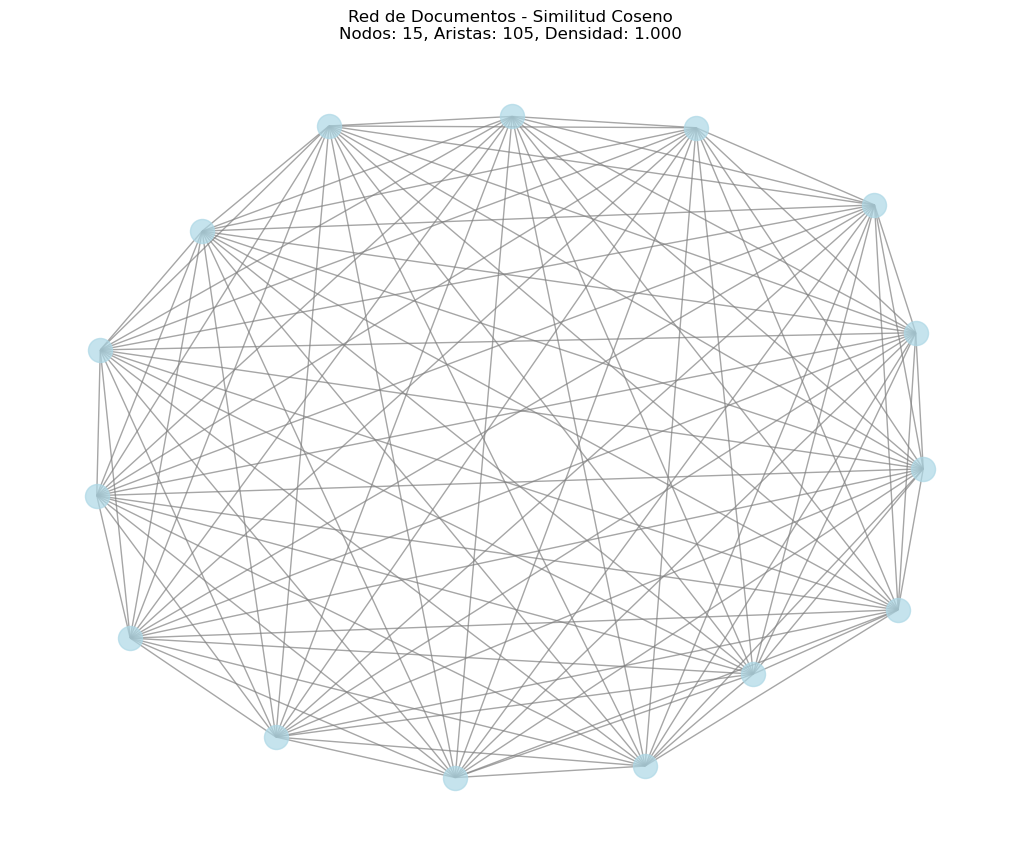

Visualizando muestra de 15 nodos de Similitud Euclidiana


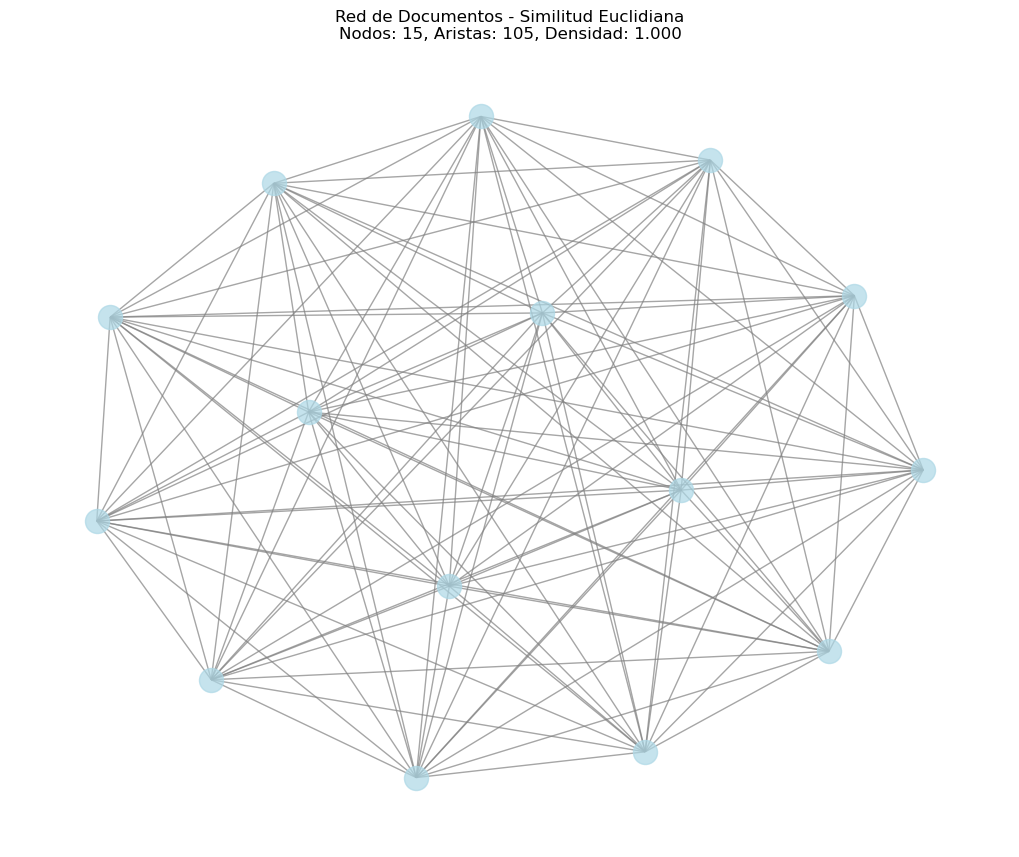

In [14]:
# Visualización opcional (muestra pequeña)
def visualize_graph_sample(G, name, max_nodes=15):
    """Visualizar muestra del grafo si tiene nodos suficientes"""
    if G.number_of_nodes() == 0:
        print(f"ADVERTENCIA {name}: Grafo vacío, no se puede visualizar")
        return
    
    # Seleccionar submuestra si el grafo es muy grande
    if G.number_of_nodes() > max_nodes:
        # Tomar el componente más grande o muestra aleatoria
        if nx.number_connected_components(G) > 1:
            largest_cc = max(nx.connected_components(G), key=len)
            nodes_to_show = list(largest_cc)[:max_nodes]
        else:
            nodes_to_show = list(G.nodes())[:max_nodes]
        subgraph = G.subgraph(nodes_to_show)
        print(f"Visualizando muestra de {len(nodes_to_show)} nodos de {name}")
    else:
        subgraph = G
        print(f"Visualizando grafo completo de {name}")
    
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(subgraph, k=1, iterations=50)
    
    # Dibujar grafo
    nx.draw(subgraph, pos, 
            node_color='lightblue', 
            node_size=300, 
            edge_color='gray',
            alpha=0.7,
            with_labels=True if subgraph.number_of_nodes() <= 10 else False,
            font_size=8)
    
    plt.title(f"Red de Documentos - {name}\n"
              f"Nodos: {subgraph.number_of_nodes()}, "
              f"Aristas: {subgraph.number_of_edges()}, "
              f"Densidad: {nx.density(subgraph):.3f}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizar ambos grafos
print("### Visualización de las Redes ###")
visualize_graph_sample(grafo_coseno, "Similitud Coseno")
visualize_graph_sample(grafo_euclidiano, "Similitud Euclidiana")

### Paso 7: Resumen Comparativo

In [15]:
# Resumen comparativo final
print("="*60)
print("RESUMEN COMPARATIVO - PERSONA 4")
print("="*60)

# Crear tabla comparativa
comparison_data = {
    'Métrica': ['Nodos', 'Aristas', 'Densidad', 'Componentes'],
    'Similitud Coseno': [
        stats_coseno['nodes'],
        stats_coseno['edges'], 
        f"{stats_coseno['density']:.4f}",
        stats_coseno['components']
    ],
    'Similitud Euclidiana': [
        stats_euclidiano['nodes'],
        stats_euclidiano['edges'],
        f"{stats_euclidiano['density']:.4f}", 
        stats_euclidiano['components']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nCOMPARACIÓN DE GRAFOS:")
print(comparison_df.to_string(index=False))

# Evaluación de conectividad
print(f"\nEVALUACIÓN DE PODA:")
print(f"Umbral Coseno: {cosine_threshold:.4f} - {stats_coseno['components']} componentes")
print(f"Umbral Euclidiano: {euclidean_threshold:.4f} - {stats_euclidiano['components']} componentes")

# Recomendación
if stats_coseno['components'] <= stats_euclidiano['components']:
    print("RECOMENDACIÓN: Similitud coseno mantiene mejor conectividad")
else:
    print("RECOMENDACIÓN: Similitud euclidiana mantiene mejor conectividad")

print("\nGrafos construidos exitosamente para análisis de topic modeling")

RESUMEN COMPARATIVO - PERSONA 4

COMPARACIÓN DE GRAFOS:
    Métrica Similitud Coseno Similitud Euclidiana
      Nodos               84                   84
    Aristas             3486                 3398
   Densidad           1.0000               0.9748
Componentes                1                    2

EVALUACIÓN DE PODA:
Umbral Coseno: -0.0010 - 1 componentes
Umbral Euclidiano: 0.3333 - 2 componentes
RECOMENDACIÓN: Similitud coseno mantiene mejor conectividad

Grafos construidos exitosamente para análisis de topic modeling


## Detección de Comunidades, Evaluación y Decisión Final

### Pasos Principales

- 1: Detección de Comunidades: Aplicar Louvain a ambos grafos.
- 2: Análisis por Cluster: Palabras top, ejemplos de usuarios, coherencia (promedio de similitud intra-cluster).
- 3: Etiquetado de Tópicos: Labels descriptivos (ej. "Practical Learning").
- 4: Evaluación: Modularidad, interpretabilidad subjetiva y separación (tamaño de clusters).
- 5: Visualización: Tablas coloreadas de tópicos (como en la imagen de ejemplo).
- 6: Decisión Final: Seleccionar la mejor medida con justificación.